In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

from qick import *
from qick.rfboard import RFQickSoc216V1

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D

In [2]:
# crank up the logging (optional)
import logging
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')

# list(logging.root.manager.loggerDict.keys())
# suppress the start/stop messages from the tproc logger
logging.getLogger('qick_processor').setLevel(logging.WARNING)

In [30]:
# Load bitstream with custom overlay
# soc = RFQickSoc216V1('/home/xilinx/jupyter_notebooks/fw/2024-12-18_216_tprocv2r21_rfbv2_standard_dcin/qick_216_rfbv2.bit')
soc = RFQickSoc216V1('/home/xilinx/jupyter_notebooks/fw/2025-01-06_216_tprocv2r21_rfbv2_standard/qick_216_rfbv2.bit')

soccfg = soc

print(soccfg)

QICK running on ZCU216, software version 0.2.302

Firmware configuration (built Sat Jan  4 11:48:37 2025):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.838 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (3.419 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 3 is 3_228, on JHC2
	4:	axis_sg_mixmux8_v1 - envelope memory 0 samples (0.000 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 

In [26]:
from qick.rfboard import *
import time

In [5]:
for iCard, card in enumerate(soc.dac_cards):
    if card is None:
        print("DAC card %d: empty"%(iCard))
    elif isinstance(card, DacDcCard216):
        print("DAC card %d: DC"%(iCard), card.chains)
    elif isinstance(card, DacRfCard216):
        print("DAC card %d: RF"%(iCard))
        print("filters:", [chain.read_filter("CHIPTYPE") for chain in card.chains])

for iCard, card in enumerate(soc.adc_cards):
    if card is None:
        print("ADC card %d: empty"%(iCard))
    elif isinstance(card, AdcDcCard216):
        print("ADC card %d: DC??"%(iCard), card.chains)
    elif isinstance(card, AdcRfCard216):
        print("ADC card %d: RF"%(iCard))
        print("filters:", [chain.read_filter("CHIPTYPE") for chain in card.chains])


DAC card 0: empty
DAC card 1: DC [<qick.rfboard.DacDcChain216 object at 0xffff47d49ed0>, <qick.rfboard.DacDcChain216 object at 0xffff47d49f60>, <qick.rfboard.DacDcChain216 object at 0xffff47d49e70>, <qick.rfboard.DacDcChain216 object at 0xffff47d49f90>]
DAC card 2: empty
DAC card 3: RF
filters: [1, 1, 1, 1]
ADC card 0: DC?? [<qick.rfboard.AdcDcChain216 object at 0xffff47d4a5c0>, <qick.rfboard.AdcDcChain216 object at 0xffff47d4a7d0>]
ADC card 1: DC?? [<qick.rfboard.AdcDcChain216 object at 0xffff47d4a8c0>, <qick.rfboard.AdcDcChain216 object at 0xffff47d4aa10>]
ADC card 2: RF
filters: [1, 1]
ADC card 3: DC?? [<qick.rfboard.AdcDcChain216 object at 0xffff47d4add0>, <qick.rfboard.AdcDcChain216 object at 0xffff47d4af50>]


In [6]:
for i, gen in enumerate(soc.gens):
    print(i, gen.rfb_ch)
    if isinstance(gen.rfb_ch, Chain216):
        print(gen.rfb_ch.global_ch)

0 None
1 None
2 None
3 None
4 <qick.rfboard.DacDcChain216 object at 0xffff47d49ed0>
4
5 <qick.rfboard.DacDcChain216 object at 0xffff47d49f60>
5
6 <qick.rfboard.DacDcChain216 object at 0xffff47d49e70>
6
7 <qick.rfboard.DacDcChain216 object at 0xffff47d49f90>
7
8 None
9 None
10 None
11 None
12 <qick.rfboard.DacRfChain216 object at 0xffff47d4a0b0>
12
13 <qick.rfboard.DacRfChain216 object at 0xffff47d4a230>
13
14 <qick.rfboard.DacRfChain216 object at 0xffff47d4a380>
14
15 <qick.rfboard.DacRfChain216 object at 0xffff47d4a4d0>
15


In [7]:
for i, buf in enumerate(soc.avg_bufs):
    print(i, buf.rfb_ch)
    if isinstance(buf.rfb_ch, Chain216):
        print(buf.rfb_ch.global_ch)

0 <qick.rfboard.AdcRfChain216 object at 0xffff47d4ab00>
4
1 <qick.rfboard.AdcDcChain216 object at 0xffff47d4add0>
6
2 <qick.rfboard.AdcRfChain216 object at 0xffff47d4ad10>
5
3 <qick.rfboard.AdcRfChain216 object at 0xffff47d4ad10>
5
4 <qick.rfboard.AdcRfChain216 object at 0xffff47d4ad10>
5
5 <qick.rfboard.AdcRfChain216 object at 0xffff47d4ad10>
5
6 <qick.rfboard.AdcRfChain216 object at 0xffff47d4ad10>
5
7 <qick.rfboard.AdcRfChain216 object at 0xffff47d4ad10>
5
8 <qick.rfboard.AdcRfChain216 object at 0xffff47d4ad10>
5
9 <qick.rfboard.AdcRfChain216 object at 0xffff47d4ad10>
5
10 <qick.rfboard.AdcDcChain216 object at 0xffff47d4a5c0>
0


In [603]:
for card_num in range(8):
    soc.board_sel.enable(board_id=card_num)                             
    if card_num<4: # DAC
        gpio = GpioMCP23S08(soc.filter_spi, ch_en=4, dev_addr=0, iodir=0xf0)
    else: # ADC
        gpio = GpioMCP23S08(soc.filter_spi, ch_en=2, dev_addr=0, iodir=0xf0)
    card_id = gpio.read_reg("GPIO_REG") >> 4                             
    print("card %d: ID %d"%(card_num, card_id))                


card 0: ID 15
card 1: ID 1
card 2: ID 15
card 3: ID 3
card 4: ID 15
card 5: ID 15
card 6: ID 2
card 7: ID 15


In [604]:
print("read bias:", soc.rfb_get_bias(0))
print("set bias:", soc.rfb_set_bias(0, 1.0))
print("read bias:", soc.rfb_get_bias(0))

read bias: 0.0
set bias: 1.0000038146972656
read bias: 1.0000038146972656


In [570]:
import xrfdc

# 0x0000F000 is only used by DAC, I think
# 0x03000000 is not used?
# https://docs.amd.com/r/en-US/pg269-rf-data-converter/XRFdc_IntrEnable
# https://docs.amd.com/r/en-US/pg269-rf-data-converter/Interrupt-Handling
# https://github.com/Xilinx/embeddedsw/blob/master/XilinxProcessorIPLib/drivers/rfdc/src/xrfdc_hw.h

def clear_interrupts(soc, verbose=False):
    interrupt_masks = [
        (0x0000000F, "XRFDC_IXR_FIFOUSRDAT_MASK"), # FIFO over/underflow, linked to XRFDC_ADC_FIFO_OVR_MASK?
        (0x00000FF0, "XRFDC_ADC_IXR_DATAPATH_MASK"), # overflow/saturation in datapath (e.g. decimation), linked to XRFDC_ADC_DAT_OVR_MASK?
        (0x00FF0000, "XRFDC_SUBADC_IXR_DCDR_MASK"), # analog input over/under full-scale range for individual sub-ADCs, linked to OVR_RANGE interrupt
        (0x04000000, "XRFDC_ADC_OVR_VOLTAGE_MASK"), # analog input exceeding ADC safe range - gen3 RFSoC
        (0x08000000, "XRFDC_ADC_OVR_RANGE_MASK"), # analog input exceeding ADC full-scale range
        (0x10000000, "XRFDC_ADC_CMODE_OVR_MASK"), # analog input common-mode voltage above spec - gen3 RFSoC
        (0x20000000, "XRFDC_ADC_CMODE_UNDR_MASK"), # analog input common-mode voltage below spec - gen3 RFSoC
        (0x40000000, "XRFDC_ADC_DAT_OVR_MASK"),
        (0x80000000, "XRFDC_ADC_FIFO_OVR_MASK"),
    ]
    arr = xrfdc._ffi.new("unsigned int [1]")
    allclear = False
    attempts = 0
    maxattempts = 5
    while not allclear:
        allclear = True
        for name, cfg in soc['adcs'].items():
            tile, block = cfg['index']
            status = xrfdc._lib.XRFdc_GetIntrStatus(soc.rf._instance, xrfdc._lib.XRFDC_ADC_TILE,tile,block,arr)
            if status != 0: print("error in reading interrupts:", status)
            interrupts = arr[0]
            if interrupts != 0:
                allclear = False
                names = []
                for mask, name in interrupt_masks:
                    if (mask & interrupts) != 0:
                        interrupts &= 0xFFFFFFFF - mask
                        names.append(name)
                if interrupts != 0: print("unrecognized interrupts:", interrupts)
                if verbose or attempts == 0:
                    print("pass %d, interrupts on tile %d block %d:"%(attempts, tile, block), hex(arr[0]), names)
                status = xrfdc._lib.XRFdc_IntrClr(soc.rf._instance, xrfdc._lib.XRFDC_ADC_TILE,tile,block,0xffffffff)
                if status != 0: print("error in clearing interrupts:", status)
        attempts += 1
        if attempts >= maxattempts:
            print("giving up")
            break
    if attempts > 1 and attempts < maxattempts:
        print("successfully cleared all interrupts in %d attempts"%(attempts-1))

In [42]:
GEN_CH=15
RO_CH=0

In [557]:
def print_attenuator(soc, ro_ch):
    tile, block = [int(x) for x in soc['readouts'][ro_ch]['adc']]
    adc = soc.rf.adc_tiles[tile].blocks[block]
    print(adc.DSA)
    
def set_attenuator(soc, ro_ch, val, verbose=False):
    tile, block = [int(x) for x in soc['readouts'][ro_ch]['adc']]
    adc = soc.rf.adc_tiles[tile].blocks[block]
    if verbose: print("before:", adc.DSA)
    adc.DSA['Attenuation'] = val
    if verbose: print("after:", adc.DSA)
    

set DAC attenuators: (0.0, 10.0)
set ADC attenuators: 25.0


  0%|          | 0/1 [00:00<?, ?it/s]

{'DisableRTS': 0, 'Attenuation': 0.0}
pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts


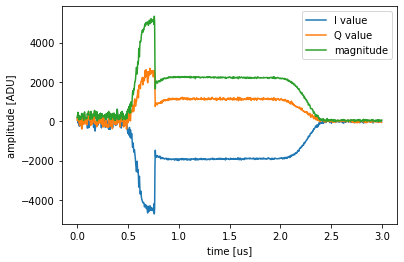

In [592]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=cfg['freq'],
                               gen_ch=gen_ch,
                               outsel='product')
        self.add_cosine(ch=gen_ch, name="ramp", length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
#                        style="const",
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'],
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
    def _body(self, cfg):
        self.delay_auto()
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'mixer_freq': 3000,
          'freq': 3000,
          'nqz': 1,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'flat_len': 1.0,
          'ramp_len': 1.0,
          'phase': 0,
          'gain': 1.0
         }
prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
freq = config['freq']
soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
set_attenuator(soc, RO_CH, 0)
# soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='lowpass', bw=1.0)
# soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='lowpass', bw=1.0)

# with RO filter bypassed, the ADC goes overrange on noise
# set_attenuator(soc, RO_CH, 10)
# soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
# soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')
print("set DAC attenuators:", soc.rfb_set_gen_rf(config['gen_ch'], 0, 10))
print("set ADC attenuators:", soc.rfb_set_ro_rf(config['ro_ch'], 25))

# clear_interrupts(soc)
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
print_attenuator(soc, RO_CH)
clear_interrupts(soc, verbose=True)

t = prog.get_time_axis(ro_index=0)
iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.plot(t, np.abs(iq.dot((1,1j))), label="magnitude")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

In [559]:
GEN_DC_CH=7
RO_DC_CH=10

DC pulse on DC-out and DC-in (note the differentiating effect of the DC-in's AC-coupled input)

set ADC gain: 10


  0%|          | 0/1 [00:00<?, ?it/s]

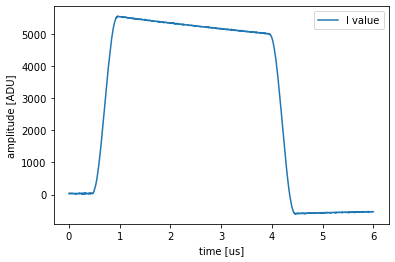

In [601]:
config = {'gen_ch': GEN_DC_CH,
          'ro_ch': RO_DC_CH,
          'mixer_freq': 0,
          'freq': 0,
          'nqz': 1,
          'trig_time': 0.0,
          'ro_len': 6.0,
          'flat_len': 3.0,
          'ramp_len': 1.0,
          'phase': 0,
          'gain': 1.0
         }
prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

set_attenuator(soc, RO_DC_CH, 0)
soc.rfb_set_gen_dc(config['gen_ch'])
print("set ADC gain:", soc.rfb_set_ro_dc(config['ro_ch'], 10))

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
clear_interrupts(soc, verbose=True)

t = prog.get_time_axis(ro_index=0)
iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
# plt.plot(t, iq[:,1], label="Q value")
# plt.plot(t, np.abs(iq.dot((1,1j))), label="magnitude")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

In [ ]:
# soc.axi_dma_avg.set_up_rx_channel()
# soc.axi_dma_buf.set_up_rx_channel()

In [399]:
tile, block = [int(x) for x in soc['readouts'][RO_CH]['adc']]
print(tile, block)
adc = soc.rf.adc_tiles[tile].blocks[block]
print(adc.DSA)
print(adc.CalFreeze)
# adc.CalFreeze['FreezeCalibration'] = 0

2 0
{'DisableRTS': 0, 'Attenuation': 5.0}
{'CalFrozen': 0, 'DisableFreezePin': 0, 'FreezeCalibration': 0}


In [ ]:
# # soc.interrupt_pins
# from pynq import Interrupt
# irq = Interrupt('usp_rf_data_converter_0/irq')
# await irq.wait()

In [126]:
from scipy.signal import welch
# from numpy.fft import fftshift
from matplotlib import colors

In [270]:
def fold_freqs(fs, target_f, freqs):
    nqz = 1+np.floor(2*freqs/fs)
    sign = (-1)**(1 + nqz%2)
    folded_freqs = (sign*freqs) % (fs/2)
    
    target_nqz = 1+np.floor(2*target_f/fs)
    target_sign = (-1)**(1 + target_nqz%2)
    return ((target_nqz)//2)*fs + target_sign*folded_freqs

In [573]:
class ToneProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=0)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
                       style="const",
                       freq=cfg['freq'],
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                       mode='periodic'
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.delay_auto()
        self.trigger(mr=True, t=1.0)

def tone_scan(gen_ch, ro_ch, center_freq, delta_freq, gain=1.0):
    config = {'gen_ch': gen_ch,
              'ro_ch': ro_ch,
              'mixer_freq': center_freq,
              'freq': center_freq,
              'nqz': 1,
              'trig_time': 0.0,
              'ro_len': 3.0,
              'flat_len': 1.0,
              'phase': 0,
              'gain': gain
             }

    fs_adc = soc['readouts'][ro_ch]['fs']
    fs_dac = soc['gens'][gen_ch]['fs']

    tone_freqs = np.linspace(center_freq-delta_freq, center_freq+delta_freq, 41)
    psd_2d = []
    for tone_freq in tqdm(tone_freqs):
        config['freq'] = tone_freq
        prog = ToneProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
        soc.arm_mr(ch=config['ro_ch'])
        iq_list = prog.run_rounds(soc, rounds=1, progress=False)
        soc.reset_gens()
        clear_interrupts(soc, verbose=False)

        iq = soc.get_mr()
#         complex_iq = iq.dot([1,1j])

        fft_freqs, psd = welch(iq[:,0], fs_adc, return_onesided=True, detrend=False, nperseg=256)
        psd_2d.append(psd)
    return fs_dac, fs_adc, tone_freqs, fft_freqs, np.array(psd_2d)


set attenuators: (20.0, 30.0)
set attenuators: 30.0


  0%|          | 0/41 [00:00<?, ?it/s]

(0.0, 1228.8)

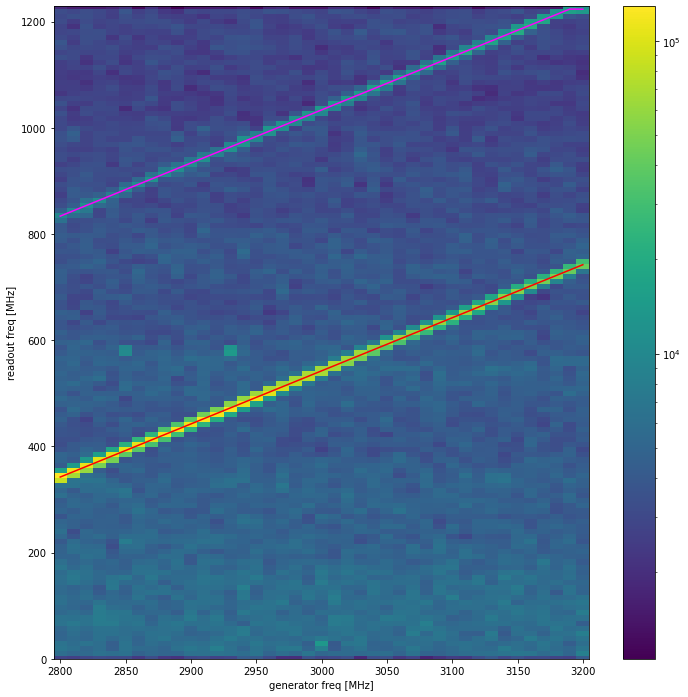

In [579]:
set_attenuator(soc, RO_CH, 5)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')
print("set attenuators:", soc.rfb_set_gen_rf(GEN_CH, 20, 30))
print("set attenuators:", soc.rfb_set_ro_rf(RO_CH, 30))

fs_dac, fs_adc, tone_freqs, fft_freqs, psd_2d = tone_scan(GEN_CH, RO_CH, center_freq=3000, delta_freq=200, gain=1.0)
fig, ax = plt.subplots(figsize=(12,12))
plt.colorbar(ax.pcolormesh(tone_freqs, fft_freqs, psd_2d.T, norm=colors.LogNorm()), ax=ax)
ax.set_ylabel("readout freq [MHz]")
ax.set_xlabel("generator freq [MHz]");
plt.plot(tone_freqs, fold_freqs(fs_adc, 0, tone_freqs), color='red', linestyle='solid')
plt.plot(tone_freqs, fold_freqs(fs_adc, 0, fs_dac-tone_freqs), color='magenta', linestyle='solid')
# plt.plot(tone_freqs, fold_freqs(fs_adc, 0, 2*tone_freqs), color='red', linestyle='dashed')
# plt.plot(tone_freqs, fold_freqs(fs_adc, 0, 3*tone_freqs), color='red', linestyle='dotted')
# plt.plot(tone_freqs, fold_freqs(fs_adc, 0, 4*tone_freqs), color='red', linestyle='dashdot')


# ax.legend()
ax.set_ylim((fft_freqs[0], fft_freqs[-1]))

In [580]:
unfolded_f = []
unfolded_psd = []
for i in range(8):
    if i%2==0:
        unfolded_f.append(((i+1)//2)*fs_adc + fft_freqs[:-1])
        unfolded_psd.append(psd_2d[:, :-1])
    else:
        unfolded_f.append(((i+1)//2)*fs_adc - fft_freqs[:0:-1])
        unfolded_psd.append(psd_2d[:, :0:-1])
unfolded_f = np.concatenate(unfolded_f)
unfolded_psd = np.concatenate(unfolded_psd, axis=1)

(0.0, 9820.8)

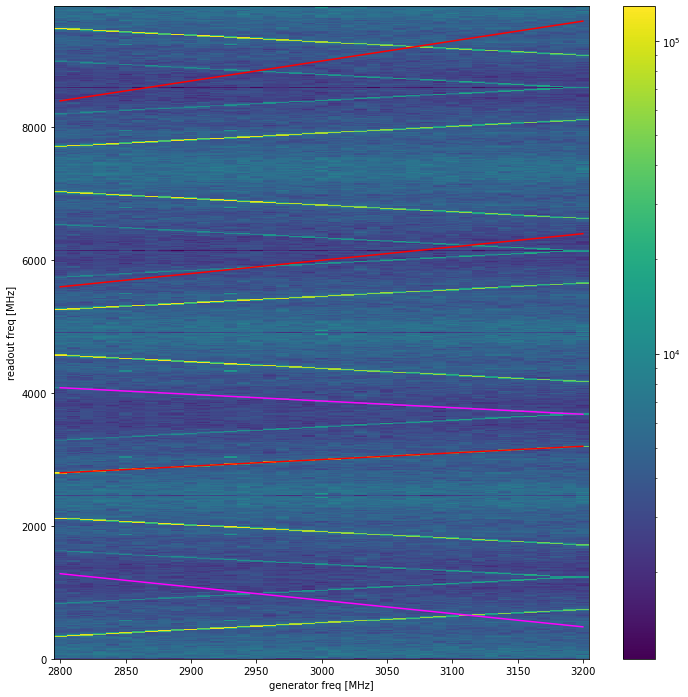

In [581]:
from matplotlib import colors
fig, ax = plt.subplots(figsize=(12,12))
plt.colorbar(ax.pcolormesh(tone_freqs, unfolded_f, unfolded_psd.T, norm=colors.LogNorm()), ax=ax)
ax.set_ylabel("readout freq [MHz]")
ax.set_xlabel("generator freq [MHz]");
plt.plot(tone_freqs, tone_freqs, color='red')
plt.plot(tone_freqs, 2*tone_freqs, color='red')
plt.plot(tone_freqs, 3*tone_freqs, color='red')

plt.plot(tone_freqs, fs_dac-tone_freqs, color='magenta')
plt.plot(tone_freqs, fs_dac-2*tone_freqs, color='magenta')
plt.plot(tone_freqs, fs_dac-3*tone_freqs, color='magenta')
ax.set_ylim((unfolded_f[0], unfolded_f[-1]))

In [217]:
# plt.plot(stacked_f[1:]-stacked_f[:-1])

In [150]:
# plt.plot(iq[:100,0])

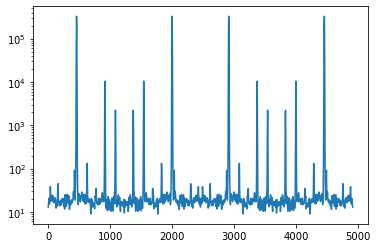

In [161]:
# plt.semilogy(np.concatenate(stacked_f), np.concatenate(stacked_psd))

  0%|          | 0/1 [00:00<?, ?it/s]

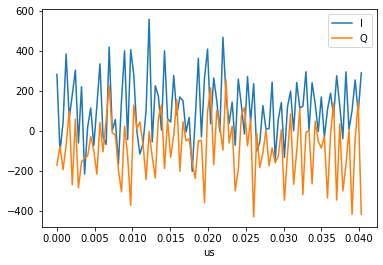

In [119]:
soc.arm_mr(ch=config['ro_ch'])
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
# look at the MR buffer just to see it works
iq_mr = soc.get_mr()[850:950]
t = prog.get_time_axis_mr(config['ro_ch'], iq_mr)
plt.plot(t, iq_mr[:,0],label="I")
plt.plot(t, iq_mr[:,1],label="Q")
plt.xlabel("us")
plt.legend();

In [37]:
class FreqSweepProgram(AveragerProgramV2): # for int gen and dyn RO
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("myloop", self.cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def _body(self, cfg):
        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])


# int gen frequency range is limited, so stitch ranges together
def measure_s21(gen_ch, ro_ch, nqz, gain, steps=101, dds_range=0.45, overlap=0, plot=False, progress=True):
    config = {'steps': steps,
              'gen_ch': gen_ch,
              'ro_ch': ro_ch,
              'nqz': nqz,
              'trig_time': 0.4,
              'pulse_len': 10.0,
              'ro_len': 10.1,
              'phase': 0,
              'gain': gain
             }
    allfreqs = []
    allpowers = []
    f_dds = soccfg['gens'][gen_ch]['f_dds']
    mixer_freqs = np.arange(0.5, 10000/f_dds, dds_range*2-overlap)*f_dds    
    for i, mixer_freq in enumerate(tqdm(mixer_freqs, disable=not progress)):
        config['mixer_freq'] = mixer_freq
        config['freq'] = QickSweep1D("myloop", mixer_freq-dds_range*f_dds, mixer_freq+dds_range*f_dds)

        prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
        freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
        iq_list = prog.acquire(soc, soft_avgs=1, progress=False)

        iq_complex = iq_list[0][0].dot([1,1j])
        mags = np.abs(iq_complex)
        powers = 20*np.log10(mags)
        allfreqs.append(freqs)
        allpowers.append(powers)
        if plot:
            plt.plot(freqs, powers, label="mixer_freq=%f"%(mixer_freq))
        #     plt.plot(freqs, mags, label="RO filter BW %.2f GHz"%(ro_bw))
            plt.ylabel("S21 [arb. dB]")
            plt.xlabel("Frequency [MHz]")
    allfreqs = np.array(allfreqs).flatten()
    allpowers = np.array(allpowers).flatten()
    return allfreqs, allpowers



  0%|          | 0/1 [00:00<?, ?it/s]

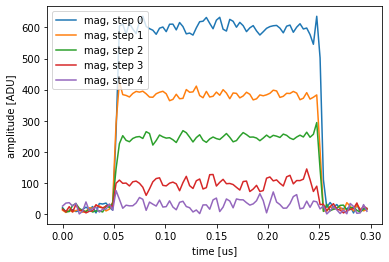

In [38]:
# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': QickSweep1D("myloop", 4500, 5500),
          'mixer_freq': 5000,
          'nqz': 2,
          'trig_time': 0.4,
          'ro_len': 0.3,
          'pulse_len': 0.2,
          'phase': 0,
          'gain': 1.0
         }

# soc.rfb_set_gen_rf(config['gen_ch'], 10, 30)
# soc.rfb_set_ro_rf(config['ro_ch'], 30)
freq = config['mixer_freq']
soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)

prog = FreqSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
#     plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
#     plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
    plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

  0%|          | 0/7 [00:00<?, ?it/s]

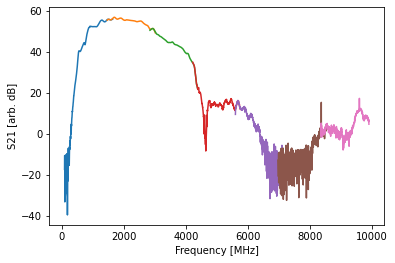

In [118]:
soc.rfb_set_gen_rf(GEN_CH, 10, 10)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')
measure_s21(GEN_CH,RO_CH,nqz=1,gain=1.0,steps=501,dds_range=0.45,overlap=0.1,plot=True);
clear_interrupts(soc)

In [ ]:
raise RuntimeError()

In [ ]:
debug=True

lmh = LMH6401()
adm = ADMV8818()

for b in range(4):

    g = gain(soc.filter_spi, ch_en=0)
    soc.board_sel.enable(board_id=b, debug=debug)
    g.set_gain(2)
    g.get_gain()

    db = 3
    msg = lmh.reg_wr(reg='GAIN_REG', val = int(g.Gmax - db))
    print(soc.filter_spi.send_receive_m(msg, g.ch_en, g.cs_t))

    msg = lmh.reg_rd(reg='GAIN_REG')
    print(soc.filter_spi.send_receive_m(msg, g.ch_en, g.cs_t))

In [ ]:
adm = ADMV8818()

msg = adm.cmd_rd(reg='CHIPTYPE')
for b in range(4):
    soc.board_sel.enable(board_id=4+b)
    for ch in range(2):
        print(soc.filter_spi.send_receive_m(msg, ch, ''))

In [ ]:
debug=True

lmh = LMH6401()
adm = ADMV8818()

msg = lmh.reg_rd(reg='GAIN_REG')
for b in range(4):
    soc.board_sel.enable(board_id=4+b)
    for ch in range(2):
        print(soc.filter_spi.send_receive_m(msg, ch, ''))

In [ ]:
for i, chain in enumerate(soc.adc_chains):
    print("ADC", i, chain.read_filter(reg='CHIPTYPE',debug=False))

In [ ]:
# soc.rfb_set_gen_dc(0)

In [ ]:
GEN_CH=15
RO_CH=0

In [ ]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=cfg['freq'],
                               gen_ch=gen_ch,
                               outsel='product')
        self.add_cosine(ch=gen_ch, name="ramp", length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
                       style="const",
#                        style="flat_top", 
#                        envelope="ramp", 
                       freq=cfg['freq'],
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
    def _body(self, cfg):
        self.delay_auto()
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'mixer_freq': 3500,
          'freq': 4000,
          'nqz': 2,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'flat_len': 1.0,
          'ramp_len': 1.0,
          'phase': 0,
          'gain': 1.0
         }
prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
freq = config['freq']
soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
# Set attenuator on DAC.
soc.rfb_set_gen_rf(config['gen_ch'], 10, 30)
# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'], 20)
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)
iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

In [ ]:
soc.arm_mr(ch=config['ro_ch'])
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
# look at the MR buffer just to see it works
iq_mr = soc.get_mr()[450:550]
t = prog.get_time_axis_mr(config['ro_ch'], iq_mr)
plt.plot(t, iq_mr[:,0],label="I")
plt.plot(t, iq_mr[:,1],label="Q")
plt.xlabel("us")
plt.legend();

In [ ]:
class FreqSweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("myloop", self.cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def _body(self, cfg):
        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': QickSweep1D("myloop", 4500, 5500),
          'mixer_freq': 5000,
          'nqz': 2,
          'trig_time': 0.4,
          'ro_len': 0.3,
          'pulse_len': 0.2,
          'phase': 0,
          'gain': 1.0
         }

soc.rfb_set_gen_rf(config['gen_ch'], 10, 30)
soc.rfb_set_ro_rf(config['ro_ch'], 30)
freq = config['mixer_freq']
soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)

prog = FreqSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
#     plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
#     plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
    plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

In [ ]:
# for chain in soc.adc_chains:
#     chain.set_filter(fc=0, ftype='bypass')
# for chain in soc.dac_chains:
#     chain.set_filter(fc=0, ftype='bypass')

In [ ]:
# for i, chain in enumerate(soc.adc_chains):
#     print("ADC", i, chain.read_filter(reg='CHIPTYPE',debug=False))
# for i, chain in enumerate(soc.dac_chains):
#     print("DAC", i, chain.read_filter(reg='CHIPTYPE',debug=False))

In [ ]:
def measure_s21(gen_ch, ro_ch, nqz, gain, steps=101, dds_range=0.45, overlap=0, plot=False, progress=True):
    config = {'steps': steps,
              'gen_ch': gen_ch,
              'ro_ch': ro_ch,
              'nqz': nqz,
              'trig_time': 0.4,
              'pulse_len': 10.0,
              'ro_len': 10.1,
              'phase': 0,
              'gain': gain
             }
    allfreqs = []
    allpowers = []
    f_dds = soccfg['gens'][gen_ch]['f_dds']
    mixer_freqs = np.arange(0.5, 10000/f_dds, dds_range*2-overlap)*f_dds    
    for i, mixer_freq in enumerate(tqdm(mixer_freqs, disable=not progress)):
        config['mixer_freq'] = mixer_freq
        config['freq'] = QickSweep1D("myloop", mixer_freq-dds_range*f_dds, mixer_freq+dds_range*f_dds)

        prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
        freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
        iq_list = prog.acquire(soc, soft_avgs=1, progress=False)

        iq_complex = iq_list[0][0].dot([1,1j])
        mags = np.abs(iq_complex)
        powers = 20*np.log10(mags)
        allfreqs.append(freqs)
        allpowers.append(powers)
        if plot:
            plt.plot(freqs, powers, label="mixer_freq=%f"%(mixer_freq))
        #     plt.plot(freqs, mags, label="RO filter BW %.2f GHz"%(ro_bw))
            plt.ylabel("S21 [arb. dB]")
            plt.xlabel("Frequency [MHz]")
    allfreqs = np.array(allfreqs).flatten()
    allpowers = np.array(allpowers).flatten()
    return allfreqs, allpowers


In [ ]:
soc.rfb_set_gen_rf(GEN_CH, 30, 30)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')
measure_s21(15,0,2,1.0,steps=501,dds_range=0.45,overlap=0.1,plot=True);

In [ ]:
soc.rfb_set_gen_rf(GEN_CH, 30, 30)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

plt.plot(*measure_s21(GEN_CH,RO_CH,1,1.0), label="nqz=1")
plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0), label="nqz=2")
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("bypass mode")
plt.legend();

In [ ]:
# just to be sure we're doing things right, set registers directly
def set_filter(gen_ch, ro_ch, lpf, hpf, filt=0):
    sw = 0xc0 + (hpf<<3) + lpf
    filt_bits = (filt<<4) + filt
    rfb_ch = soc.gens[gen_ch].rfb
    rfb_ch.brd_sel.enable(rfb_ch.rfboard_ch)
    rfb_ch.filter.reg_wr('WR0_SW', sw)
    rfb_ch.filter.reg_wr('WR0_FILTER', filt_bits)
    rfb_ch.brd_sel.disable()

    rfb_ch = soc.avg_bufs[ro_ch].rfb
    rfb_ch.brd_sel.enable(rfb_ch.rfboard_ch)
    rfb_ch.filter.reg_wr('WR0_SW', sw)
    rfb_ch.filter.reg_wr('WR0_FILTER', filt_bits)
    rfb_ch.brd_sel.disable()


In [ ]:
soc.rfb_set_gen_rf(GEN_CH, 30, 30)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for lpf in tqdm(range(0,5)):
    set_filter(GEN_CH, RO_CH, lpf, 0, 0)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="lpf=%d"%(lpf))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("LPF bands, state=0")
plt.legend();

In [ ]:
soc.rfb_set_gen_rf(GEN_CH, 30, 30)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for state in tqdm(range(0,16)):
    set_filter(GEN_CH, RO_CH, 2, 0, state)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="state=%d"%(state))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("LPF states, band=2")
plt.legend();

In [ ]:
soc.rfb_set_gen_rf(GEN_CH, 30, 30)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for hpf in tqdm(range(0,5)):
    set_filter(GEN_CH, RO_CH, 0, hpf, 0)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="hpf=%d"%(hpf))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("HPF bands, state=0")
plt.legend();

In [ ]:
soc.rfb_set_gen_rf(GEN_CH, 30, 30)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for state in tqdm(range(0,16)):
    set_filter(GEN_CH, RO_CH, 0, 2, state)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="state=%d"%(state))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("HPF states, band=2")
plt.legend();

In [ ]:
soc.rfb_set_gen_rf(config['gen_ch'], 10, 30)
soc.rfb_set_ro_rf(config['ro_ch'], 20)
freq = 6000
for bw in tqdm([1500, 1000, 500, 200, 100]):

    soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=bw/1000)
    soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=bw/1000)


    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="bw=%.2f"%(bw))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("filter center = %.2f MHz"%(freq));
plt.legend();


## scratchwork below, ignore

In [ ]:
from tqdm.auto import tqdm
config['ro_len'] += 10.0
config['pulse_len'] += 10.0
config['freq'] = QickSweep1D("myloop", 3800, 4200)
# config['freq'] = QickSweep1D("myloop", 3000, 7000)
config['steps']=1001

freq = 5000
soc.rfb_set_gen_filter(config['gen_ch'], fc=0, ftype='bypass')
soc.rfb_set_ro_filter(config['ro_ch'], fc=0, ftype='bypass')

for ro_bw in tqdm([1.5, 1.0, 0.5, 0.2, 0.1]):
#     soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=ro_bw)
#     soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=ro_bw)

    prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
    freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
    iq_list = prog.acquire(soc, soft_avgs=1, progress=False)

    iq_complex = iq_list[0][0].dot([1,1j])
    mags = np.abs(iq_complex)

    plt.semilogy(freqs, mags, label="RO filter BW %.2f GHz"%(ro_bw))
    # plt.ylabel("Phase [cycles]")
    # plt.xlabel("Frequency [MHz]")

    # print("phase step (cycles):", phases[1]-phases[0])

plt.title("filter center = %f MHz"%(freq))
plt.legend();

In [ ]:
from tqdm.auto import tqdm
config['ro_len'] += 10.0
config['pulse_len'] += 10.0
config['freq'] = QickSweep1D("myloop", 3800, 4200)
# config['freq'] = QickSweep1D("myloop", 3000, 7000)
config['steps']=1001

freq = 5000
soc.rfb_set_gen_filter(config['gen_ch'], fc=0, ftype='bypass')
soc.rfb_set_ro_filter(config['ro_ch'], fc=0, ftype='bypass')

for ro_bw in tqdm([1.5, 1.0, 0.5, 0.2, 0.1]):
#     soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=ro_bw)
#     soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=ro_bw)

    prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
    freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
    iq_list = prog.acquire(soc, soft_avgs=1, progress=False)

    iq_complex = iq_list[0][0].dot([1,1j])
    mags = np.abs(iq_complex)

    plt.semilogy(freqs, mags, label="RO filter BW %.2f GHz"%(ro_bw))
    # plt.ylabel("Phase [cycles]")
    # plt.xlabel("Frequency [MHz]")

    # print("phase step (cycles):", phases[1]-phases[0])

plt.title("filter center = %f MHz"%(freq))
plt.legend();

In [ ]:
print(prog.get_pulse_param('myro', 'freq', as_array=True))
print(prog.get_pulse_param('mypulse', 'freq', as_array=True))


In [ ]:
class SimpleSweepProgram2(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch, name="myro", 
                               freq=cfg['freq'], 
                               gen_ch=gen_ch, 
                               outsel='input')

#         self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
#         self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
#                        style="flat_top", 
#                        envelope="ramp", 
#                        freq=cfg['freq'], 
#                        length=cfg['flat_len'],
#                        phase=cfg['phase'],
#                        gain=cfg['gain'], 
#                       )
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
#                        mode='periodic'
                      )

        
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)

In [ ]:
# do a sweep with 5 points and plot decimated
config = {'gen_ch': 2,
          'ro_ch': 1,
          'freq': 5000,
          'nqz': 1,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'flat_len': 0.5,
          'ramp_len': 0.2,
          'phase': 0,
          'gain': 1.0
         }

prog = SimpleSweepProgram2(soccfg, reps=1, final_delay=0.5, cfg=config)



freq = config['freq']

soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bypass')
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bypass')



# Set Filter.
# soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass')
# soc.rfb_set_gen_filter(config['gen_ch'], fc=2.5, ftype='lowpass')

# Set attenuator on DAC.
# soc.rfb_set_gen_rf(config['gen_ch'], 5, 5)
soc.rfb_set_gen_rf(config['gen_ch'], 10, 30)

#######
# ADC #
#######
# Set Filter.
# soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass')

# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'], 30)


iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
# plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

In [ ]:
soc.arm_mr(ch=config['ro_ch'])
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
# look at the MR buffer just to see it works
iq_mr = soc.get_mr()[800:900]
t = prog.get_time_axis_mr(config['ro_ch'], iq_mr)
plt.plot(t, iq_mr[:,0],label="I")
plt.plot(t, iq_mr[:,1],label="Q")
plt.xlabel("us")
plt.legend();

In [ ]:
from scipy.signal import welch
from numpy.fft import fftshift

soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bypass')
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bypass')

# soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bypass')
# soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass')

soc.arm_mr(ch=config['ro_ch'])
iq_list = prog.acquire_decimated(soc, soft_avgs=1)

iq_mr = soc.get_mr()[:,0]
fs_mr = soccfg['readouts'][config['ro_ch']]['fs']
# fft_freqs, psd = fftshift(welch(iq_mr, fs_mr, return_onesided=True, nperseg=128, detrend=False), axes=1)
fft_freqs, psd = welch(iq_mr, fs_mr, return_onesided=True, nperseg=128, detrend=False)
plt.semilogy(fft_freqs, psd)
plt.xlabel("MHz")

In [ ]:
for chain in soc.dac_chains:
    chain.set_filter(fc=1.5, bw=1, ftype='bypass')
    chain.set_rf(5,5)

In [ ]:
for chain in soc.adc_chains:
    chain.set_filter(fc=1.5, bw=1, ftype='bypass')
    chain.set_attn_db(5)

In [ ]:
rfb_cfg = {'gen_ch': 2,
        'ro_ch': 1,
        'gen_att': (10,30),
        'ro_att': 30,
        }
soc.rfb_set_gen_rf(rfb_cfg['gen_ch'], *rfb_cfg['gen_att'])
soc.rfb_set_ro_rf(rfb_cfg['ro_ch'], rfb_cfg['ro_att'])

soc.rfb_set_ro_filter(rfb_cfg['ro_ch'], fc=1.0, ftype='bypass')
soc.rfb_set_gen_filter(rfb_cfg['gen_ch'], fc=1.0, ftype='bypass')


In [ ]:
class FreqSweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("myloop", self.cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def _body(self, cfg):
        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': 2,
          'ro_ch': 1,
          'freq': QickSweep1D("myloop", 4000, 7000),
          'nqz': 2,
          'trig_time': 0.4,
          'ro_len': 0.3,
          'pulse_len': 0.2,
          'phase': 0,
          'gain': 1.0
         }

soc.rfb_set_gen_rf(config['gen_ch'], 10, 30)
soc.rfb_set_ro_rf(config['ro_ch'], 30)

prog = FreqSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
#     plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
#     plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
    plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

In [ ]:
from tqdm.auto import tqdm
config['freq'] = QickSweep1D("myloop", 3000, 6000)
config['steps']=5001

freq = 5000

for ro_bw in tqdm([1.5, 1.0, 0.5, 0.2, 0.1]):
#     soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bypass')

    soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=ro_bw)
#     for chain in soc.adc_chains:
# #         chain.set_filter(fc=5.0, ftype='bandpass', bw=ro_bw)
#         chain.set_filter(fc=9.0, ftype='lowpass', bw=ro_bw)

#     soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=ro_bw)
#     soc.rfb_set_gen_filter(config['gen_ch'], fc=3.0, ftype='bandpass', bw=0.5)

    prog = FreqSweepProgram(soccfg, reps=100, final_delay=1.0, cfg=config)
    freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
    iq_list = prog.acquire(soc, soft_avgs=1, progress=False)
    # plt.plot(np.angle(iq_list[0][0].dot([1,1j]), deg=True))
    # plt.plot(iq_list[0][0,:,0], iq_list[0][0,:,1], '.')
    # plt.ylabel("Q [ADU]")
    # plt.xlabel("I [ADU]");

    iq_complex = iq_list[0][0].dot([1,1j])
    mags = np.abs(iq_complex)

    plt.semilogy(freqs, mags, label="RO filter BW %.2f GHz"%(ro_bw))
    # plt.ylabel("Phase [cycles]")
    # plt.xlabel("Frequency [MHz]")

    # print("phase step (cycles):", phases[1]-phases[0])

plt.title("filter center = %f MHz"%(freq))
plt.legend();

In [ ]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch, name="myro", 
                               freq=cfg['freq'], 
                               gen_ch=gen_ch, 
                               outsel=cfg['ro_outsel'])

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
        ramp_len = 2.0
#         self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        self.add_triangle(ch=gen_ch, name="triangle", length=ramp_len, even_length=True)
        
#         self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
#                        style="arb", 
#                        envelope="ramp", 
#                        freq=cfg['freq'], 
#                        phase=0,
#                        gain=1.0, 
#                       )
        self.add_pulse(ch=gen_ch, name="mytri", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="triangle", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )
        
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mytri", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)
        
        
        
config = {'gen_ch': 2,
          'ro_ch': 1,
          'freq': 3000,
          'nqz': 1,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'ro_outsel': 'product',
          'pulse_len': 0.5,
          'phase': 0,
          'gain': 1.0
         }

prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

freq = config['freq']

# soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bypass')
# soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bypass')



# # Set Filter.
# # soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass')
# # soc.rfb_set_gen_filter(config['gen_ch'], fc=2.5, ftype='lowpass')

# # Set attenuator on DAC.
# # soc.rfb_set_gen_rf(config['gen_ch'], 5, 5)
# soc.rfb_set_gen_rf(config['gen_ch'], 5, 20)

# #######
# # ADC #
# #######
# # Set Filter.
# # soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass')

# # Set attenuator on ADC.
# soc.rfb_set_ro_rf(config['ro_ch'], 20)

rfb_cfg = {'gen_ch': 2,
        'ro_ch': 1,
        'gen_att': (10,30),
        'ro_att': 30,
        }
soc.rfb_set_gen_rf(rfb_cfg['gen_ch'], *rfb_cfg['gen_att'])
soc.rfb_set_ro_rf(rfb_cfg['ro_ch'], rfb_cfg['ro_att'])

soc.rfb_set_ro_filter(rfb_cfg['ro_ch'], fc=1.0, ftype='bypass')
soc.rfb_set_gen_filter(rfb_cfg['gen_ch'], fc=1.0, ftype='bypass')

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
# plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

In [ ]:
##########################################
### One generator/readout and raw-data ###
##########################################
class ReadoutTest(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone for the DACs.
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=self.cfg['gen_nqz'])
        
        # DAC channel.
        freq = self.freq2reg(self.cfg['pulse_freq'], gen_ch=self.cfg['gen_ch'], ro_ch=self.cfg['ro_ch'][0])
        self.set_pulse_registers(ch     = self.cfg['gen_ch'], 
                                 style  = 'const', 
                                 freq   = freq,
                                 phase  = 0, 
                                 gain   = self.cfg['pulse_gain'], 
                                 length = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch']))
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'][0], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][0]),
                             freq    = self.cfg['ro_freq'],
                             gen_ch  = self.cfg['gen_ch'])
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):       
        self.measure(pulse_ch        = self.cfg['gen_ch'], 
                     adcs            = self.cfg['ro_ch'],
                     pins            = [0],
                     t               = self.us2cycles(self.cfg['pulse_start']),
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                     )        

config={"ro_ch"       : [5],
        "ro_length"   : 40,
        "ro_freq"     : 4000,
        "ro_offset"   : 0,
        
        "gen_ch"      : 12,        
        "gen_nqz"     : 2,
        "pulse_length": 20,
        "pulse_start" : 10,
        "pulse_gain"  : 30000,
        "pulse_freq"  : 4000,
        
        "reps"        : 1,
        "period"      : 20
       }

########################
### RF Board Setting ###
########################

#######
# DAC #
#######
freq = config['pulse_freq']

# Set Filter.
# soc.rfb_set_gen_filter(config['gen_ch'], fc=fc, ftype='bandpass')
soc.rfb_set_gen_filter(config['gen_ch'], fc=2.5, ftype='lowpass')

# Set attenuator on DAC.
soc.rfb_set_gen_rf(config['gen_ch'], 15, 20)

#######
# ADC #
#######
# Set Filter.
soc.rfb_set_ro_filter(config['ro_ch'][0], fc=freq/1000, ftype='bandpass')

# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'][0], 20)

prog = ReadoutTest(soccfg, config)
iq_list = prog.acquire_decimated(soc)

# Plot Captured Data.
plt.figure(dpi=200)

yi = iq_list[0][0]
yq = iq_list[0][1]
t = soccfg.cycles2us(ro_ch=config['ro_ch'][0], cycles=np.arange(len(iq_list[0][0])))

plt.plot(t,yi)
plt.plot(t,yq)
    
plt.xlabel('t [us]');
plt.legend(['I','Q']);


In [ ]:
from tqdm.auto import tqdm
for i in tqdm(range(1000)):
    soc.rfb_set_gen_rf(gen_ch=0, att1=15, att2=20)


### little note on the generator outputs
This firmware uses the "tmux" which multiplexes multiple generators onto each tProc output. Generally this works transparently, but be aware that if you try to play simultaneous pulses on generators that share a tmux channel, the pulses will get offset by a tProc clock cycle (or something like that).

In [ ]:
soccfg['gens']

In [ ]:
[(i,gen['tproc_ch']) for i,gen in enumerate(soccfg['gens'])]

In [ ]:
soc.ip_dict.keys()

### playing with LEDs (and ribbon I/O connector)
The LEDs are wired to the PMOD0 connector on the ZCU216, the ribbon is wired to PMOD1. In this firmware these are connected to an AxiGPIO which is controlled by software (vs. in most QICK firmware, where the PMODs are connected to the tProc). So these are for slow control.

The LEDs are very dim (trying to drive the LEDs directly with PMOD outputs?).

There is also some weirdness with the AxiGPIO we're using for this.

The ribbon connector works identically (`soc.pmod_bits_gpio` instead of `soc.pmod_led_gpio`), except that the pin mapping seems to be screwed up somewhere, such that even and odd pins are swapped: PMOD1_0=ribbon signal 1, PMOD 1_1=ribbon signal 0, etc. The ribbon pins should be input-capable, but I haven't checked.

In [ ]:
help(soc.pmod_led_gpio)

In [ ]:
# this works
while True:
    for ch in soc.pmod_led_gpio:
        ch.on()
    time.sleep(1)
    for ch in soc.pmod_led_gpio:
        ch.off()
    time.sleep(1)
    

In [ ]:
# this works
while True:
    for i in range(8):
        for j in range(8):
            if i==j:
                soc.pmod_led_gpio[j].on()
            else:
                soc.pmod_led_gpio[j].off()
        time.sleep(0.2)

In [ ]:
# this works
while True:
    for i in range(8):
        for j in range(8):
            if i==j:
                soc.pmod_led_gpio[j].write(1)
            else:
                soc.pmod_led_gpio[j].write(0)
        time.sleep(0.2)

In [ ]:
# this works
while True:
    for i in range(8):
        soc.pmod_led_gpio.channel1.write(val=1<<i, mask=0xFF)
        time.sleep(0.2)


In [ ]:
# this doesn't work, not sure why
while True:
    soc.pmod_led_gpio.channel1.write(0x0,0xFF)
    time.sleep(1)
    soc.pmod_led_gpio.channel1.write(0xFF,0xFF)
    time.sleep(1)
    

In [ ]:
help(soc.pmod_led_gpio.channel1.write)